In [66]:
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [67]:
import yfinance as yf

start_date = '2019-03-01'
end_date = '2024-06-01'
symbol = 'ABBV'

data = yf.download(symbol, start=start_date, end=end_date)
data.to_csv('AbbVie_data.csv')

[*********************100%%**********************]  1 of 1 completed


In [68]:
df = pd.read_csv('AbbVie_data.csv')
df1 = df.reset_index()['Open']

In [69]:
print(df1)

0        79.769997
1        80.400002
2        79.379997
3        79.129997
4        77.769997
           ...    
1254    177.259995
1255    178.839996
1256    178.770004
1257    179.850006
1258    177.869995
Name: Open, Length: 1259, dtype: float64


In [70]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [71]:
train_size = int(0.9 * len(df))
test_size = int(0.1 * len(df))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [72]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [73]:
X_train

array([[0.13976274, 0.14517794, 0.1364105 , ..., 0.03979715, 0.04289154,
        0.03859379],
       [0.14517794, 0.1364105 , 0.13426163, ..., 0.04289154, 0.03859379,
        0.0366168 ],
       [0.1364105 , 0.13426163, 0.12257175, ..., 0.03859379, 0.0366168 ,
        0.03395221],
       ...,
       [0.38112427, 0.39272817, 0.38456248, ..., 0.69821215, 0.69872786,
        0.69778235],
       [0.39272817, 0.38456248, 0.38963379, ..., 0.69872786, 0.69778235,
        0.66821383],
       [0.38456248, 0.38963379, 0.39436134, ..., 0.69778235, 0.66821383,
        0.71093345]])

In [74]:
model=RandomForestRegressor()

In [75]:
grid_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': np.arange(5, 20, 2),
    'min_samples_split': [3, 6, 9],
    'min_samples_leaf': [2, 3, 5, 7],
    'bootstrap': [True, False],
    'random_state': [10, 20, 30, 40]
}
 
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(X_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] END bootstrap=True, max_depth=17, min_samples_leaf=5, min_samples_split=3, n_estimators=50, random_state=40; total time=   0.7s
[CV] END bootstrap=True, max_depth=17, min_samples_leaf=5, min_samples_split=3, n_estimators=50, random_state=40; total time=   0.7s
[CV] END bootstrap=True, max_depth=17, min_samples_leaf=5, min_samples_split=3, n_estimators=50, random_state=40; total time=   0.8s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=7, min_samples_split=3, n_estimators=150, random_state=40; total time=   1.9s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=7, min_samples_split=3, n_estimators=150, random_state=40; total time=   2.0s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=7, min_samples_split=3, n_estimators=150, random_state=40; total time=   2.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=200, random_state=30; total time=   2.5s
[CV] E

In [76]:
best_parameters

{'random_state': 40,
 'n_estimators': 50,
 'min_samples_split': 9,
 'min_samples_leaf': 3,
 'max_depth': 5,
 'bootstrap': True}

In [77]:
model = RandomForestRegressor(n_estimators=best_parameters['n_estimators'], random_state=best_parameters['random_state'], min_samples_split=best_parameters['min_samples_split'],
                              min_samples_leaf=best_parameters['min_samples_leaf'], max_depth=best_parameters['max_depth'], bootstrap=best_parameters['bootstrap'])
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=3, min_samples_split=9,
                      n_estimators=50, random_state=40)

In [78]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [79]:
# Chuẩn hóa dữ liệu dự đoán
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

In [80]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))


In [81]:
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, y_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, y_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 4))


Mean Absolute Error: 9.3334
Mean Squared Error: 147.454
Root Mean Squared Error: 12.1431


In [82]:
# Dự báo cho 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        i += 1

lst_output = np.array(lst_output).reshape(-1, 1)


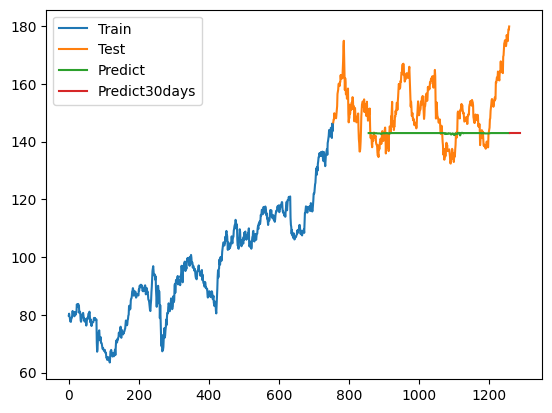

In [83]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()